![dd](https://miro.medium.com/max/559/0*irl4HR2657jhUAt4)

In [1]:
####import libraries

import pandas as pd
import numpy as np
from operator import itemgetter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,make_scorer,fbeta_score
from sklearn.metrics import average_precision_score,plot_precision_recall_curve,precision_recall_curve
from sklearn.metrics import roc_auc_score,roc_curve, auc, brier_score_loss

from sklearn.decomposition import TruncatedSVD
import catboost as cb
import clean_text as ct

#### Dataset import and some quick exploration

In [2]:
# tweets = pd.read_csv('climate_change_tweets_sample-2020-05-16-17-57.csv')
# tweets.head()

In [3]:
# clean_text = ct.CleanText()
# tweets["text"] = clean_text.fit_transform(tweets.text)
# tweets.to_csv("clean_tweets.csv") # save once processed

In [4]:
tweets = pd.read_csv("clean_tweets.csv") # read in instead
tweets = tweets.loc[(~tweets.text.isnull()), :]
tweets.head()

,Unnamed: 0,username,user_handle,date,retweets,favorites,text,label
0,0,WWF Climate & Energy,climateWWF,2020-04-28,11,22,econom recoveri nation climat pledg must desig...,0
1,1,WWF Climate & Energy,climateWWF,2020-04-22,6,16,difficult time hard connect natur world earthd...,0
2,2,WWF Climate & Energy,climateWWF,2020-04-01,43,69,decis postpon cop unavoid collect prioriti mus...,0
3,3,WWF Climate & Energy,climateWWF,2020-03-30,24,30,japan world fifth largest emitt greenhous gase...,0
4,4,WWF Climate & Energy,climateWWF,2020-03-30,22,40,countri includ naturebasedsolut climat plan nd...,0


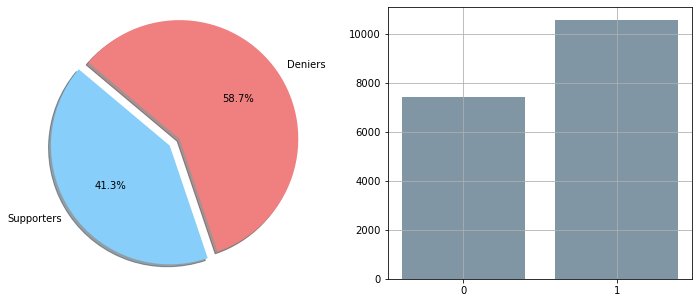

In [5]:
# Data to plot
fig, ax = plt.subplots(figsize=(12,5),nrows=1,ncols=2)

labels = 'Supporters', 'Deniers'
sizes = len(tweets.label.values[tweets.label.values==0]),len(tweets.label.values[tweets.label.values==1])
colors = ['lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
ax[0].pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

ax[0].axis('equal')


labels, counts = np.unique(tweets.label.values, return_counts=True)
ax[1].bar(labels, counts, align='center',color='#607c8e',alpha=0.8)
ax[1].set_xticks(labels)
ax[1].grid()


plt.show()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(tweets.text, tweets.label, 
                                                    test_size=0.2, random_state=17, 
                                                    shuffle=True) # explicit default

###### Bag-Of-Words and Scaling

![BagOfWords](https://www.novuslight.com/uploads/n/BagofWords.jpg)

In [7]:
BOW_vectorizer = CountVectorizer(stop_words = 'english', 
                                 binary=True, # Creates 0/1 "One Hot" vector; 
                                              # np.unique(BOW_train.toarray())
                                 min_df = 10)
BOW_vectorizer.fit(X_train)
BOW_train = BOW_vectorizer.transform(X_train)
BOW_test = BOW_vectorizer.transform(X_test)


#### BE CAREFUL!!!! ####
scaler_BOW = MaxAbsScaler()  ####<-- For BOW scaling is reduntant, but I do it in matters of consistency.

X_train = scaler_BOW.fit_transform(BOW_train)
X_test = scaler_BOW.transform(BOW_test)

## CatBoostingClassifier

The newest of the popular gradient boosting libraries, **CatBoost (Categorical Boosting)** was developed by the Russian tech company Yandex in mid-2017, following closely on the heels of *LightGBM*. Catboost it is again an ensemble of weak learners *(decision trees)* that can be used for solving problems, such as regression, classification, multi-class classification and ranking. It has the flexibility of giving indices of categorical columns so that it can be encoded as one-hot encoding using one_hot_max_size (Use one-hot encoding for all features with number of different values less than or equal to the given parameter value). If you don’t pass any anything in cat_features argument, CatBoost will treat all the columns as numerical variables. So it is meant for cases such as categorical and text data.

Catboost introduces the followign algorithmic advances:

* An innovative algorithm for processing categorical features. No need to preprocess features on your own — it’s performed out of the box. For data with categorical features the accuracy would be better compare to other algorithm.
* The implementation of ordered boosting, a permutation-driven alternative to the classic bosting algorithm. On small datasets, the GB is quickly overfitted. In Catboost there is a special modification for such cases. That is, on those datasets where other algorithms had a problem with overfitted you won’t observe the same problem on Catboost.
* Fast and easy to-use GPU-training. It can outperforms its predecessor with training time 8 x times faster than they do.
* Other useful features: missing value support, great visualization.



#### A concise comparison between XGBoost CATBoost AND LGBoost hyperparameters:

<br>

![hyperparameters comparison](https://cdn-images-1.medium.com/max/2600/1*A0b_ahXOrrijazzJengwYw.png)

###### Hyper-Parameters Selection

In [8]:
##After some Grid-Search exploration:

params = {"border_count": 20, "depth": 9, "l2_leaf_reg": 10, "learning_rate": 0.3, "n_estimators": 1000,
          "random_state":17,"thread_count":4,"verbose":0}

# learning_rate: Corresponds to how quickly the error is corrected from each tree to the next and is a simple multiplier 0<LR≤1.
# l2-leaf-reg: Coefficient at the L2 regularization term of the cost function.
# border_count: The number of splits for numerical features. 
# n_estimators(alias) --> Iterations: The maximum number of trees that can be built when solving machine learning problems.
# thread_count(alis) --> n_jobs: The number of threads to use during the training (-1 uses all process cores available).

In [9]:
#instantiate classifier

clf =  cb.CatBoostClassifier(**params)
clf.fit(X_train,y_train)

###### Classifier Performace

In [10]:
def plot_figure(X,y,clf):
    '''Plots Precision-Recall & ROC curves'''

    y_score = clf.predict_proba(X)[:, 1]
    average_precision = average_precision_score(y, y_score)

    print('Average precision-recall score: {0:0.2f}'.format(
          average_precision))

    fig, axes = plt.subplots(figsize=(12,5),nrows=1,ncols=2)
    disp = plot_precision_recall_curve(clf, X, y,ax=axes[0])
    disp.ax_.set_title('2-class Precision-Recall curve: '
                       'AP={0:0.2f}'.format(average_precision))
    axes[0].legend(loc="lower left")
    axes[0].grid()


    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)

    #plt.figure()
    lw = 2
    axes[1].plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    axes[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Receiver Operating Characteristic Curve')
    axes[1].legend(loc="lower right")
    axes[1].grid()
    
    plt.show()

#######################

Accuracy: 0.9084
Precision: 0.922
Recall: 0.9238
F1_score: 0.9229
F2_score: 0.9234
F5_score: 0.9237
AUC_score: 0.969
1-Brier_score: 0.9342

#######################

Average precision-recall score: 0.98


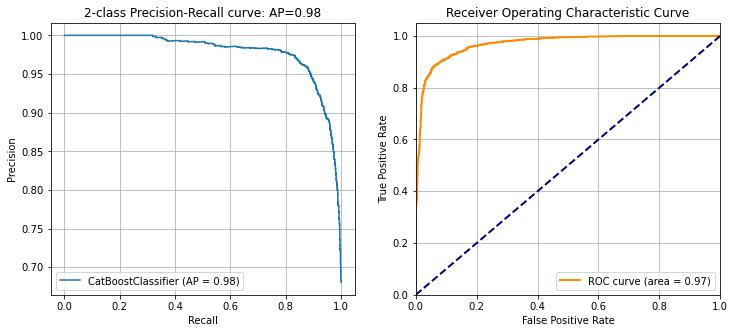

In [15]:
pred = clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
precision = precision_score(y_test,pred)
recall = recall_score(y_test,pred)
f1 = f1_score(y_test,pred)
f2 = fbeta_score(y_test,pred,beta=2)
f5 = fbeta_score(y_test,pred,beta=5)
y_score = clf.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test,y_score)
brier_score = brier_score_loss(y_test, y_score)


print('#######################\n')
print('Accuracy: {}'.format(round(accuracy,4)))
print('Precision: {}'.format(round(precision,4)))
print('Recall: {}'.format(round(recall,4)))
print('F1_score: {}'.format(round(f1,4)))
print('F2_score: {}'.format(round(f2,4)))
print('F5_score: {}'.format(round(f5,4)))
print('AUC_score: {}'.format(round(auc_score,4)))
print('1-Brier_score: {}'.format(round(1-brier_score,4)))
print()
print('#######################\n')


plot_figure(X_test,y_test,clf)

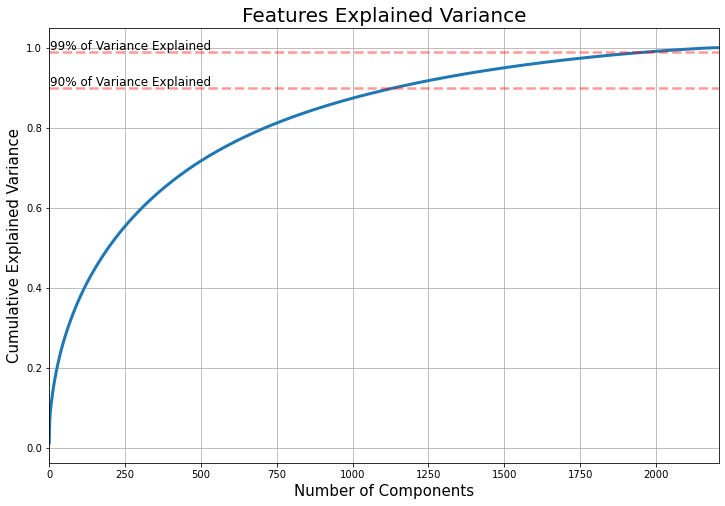

In [12]:
T_SVD = TruncatedSVD(n_components=X_train.shape[1]-1).fit(X_train) #X Vector is very......SPARSE

plt.figure(figsize=(12,8))
plt.plot(np.cumsum(T_SVD.explained_variance_ratio_),linewidth=3)
plt.axhline(y=0.9,color='r',alpha=0.4,linewidth=2.5,linestyle='--')
plt.text(1,0.905,'90% of Variance Explained', fontsize=12)
plt.axhline(y=0.99,color='r',alpha=0.4,linewidth=2.5,linestyle='--')
plt.text(1,0.995,'99% of Variance Explained', fontsize=12)
plt.xlabel('Number of Components',fontsize=15)
plt.ylabel('Cumulative Explained Variance',fontsize=15)
plt.title('Features Explained Variance',fontsize=20)
plt.xlim(0,X_train.shape[1])
plt.grid()

Interesting Notation: **Increases Logarithmically**

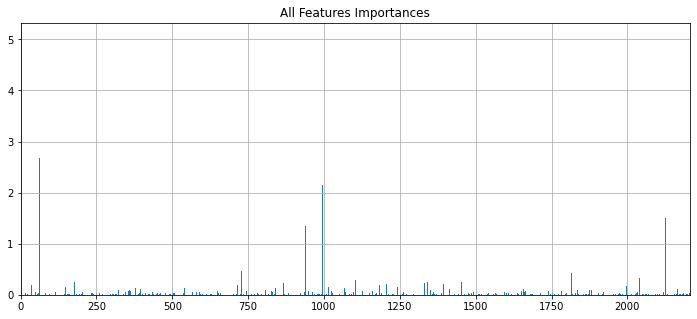

In [13]:
importance = clf.get_feature_importance()

plt.figure(figsize=(12,5))
plt.bar([x for x in range(len(importance))], importance)
plt.ylim(0,max(importance))
plt.xlim(0,len(importance))
plt.title('All Features Importances')
plt.grid()
plt.show()

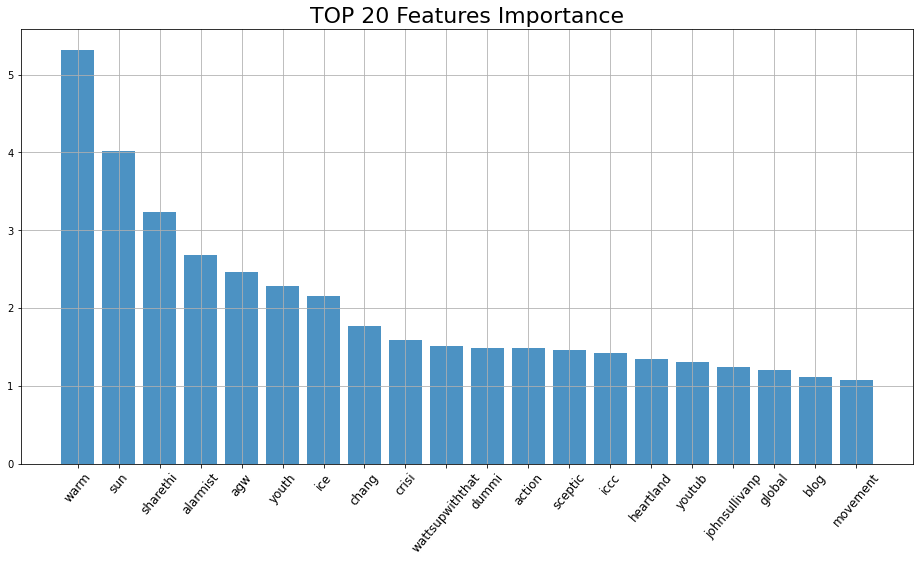

In [17]:
indices, importance_sorted = zip(*sorted(enumerate(importance), key=itemgetter(1),reverse=True))

indices,importance_sorted = indices[:20],importance_sorted[:20]

feature_names = BOW_vectorizer.get_feature_names()
top_features = [feature_names[i] for i in indices]

plt.figure(figsize=(16,8))
plt.bar([x for x in range(len(importance_sorted))], importance_sorted,align='center',alpha=0.8)
plt.xticks(ticks=range(len(top_features)),labels=top_features,rotation=50,fontsize=12)
plt.title('TOP 20 Features Importance',fontsize=22)
plt.grid()
plt.show()

#### References:


* CatBoost Webpage: [https://catboost.ai/](https://catboost.ai/)
* Github Repository: [https://github.com/catboost/catboost](https://github.com/catboost/catboost)
* CatBoost vs. Light GBM vs. XGBoost: [https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)
* Boosting Showdown: Scikit-Learn vs XGBoost vs LightGBM vs CatBoost in Sentiment Classification: [https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956](https://towardsdatascience.com/boosting-showdown-scikit-learn-vs-xgboost-vs-lightgbm-vs-catboost-in-sentiment-classification-f7c7f46fd956)
* Introduction to gradient boosting on decision trees with Catboost: [https://towardsdatascience.com/introduction-to-gradient-boosting-on-decision-trees-with-catboost-d511a9ccbd14](https://towardsdatascience.com/introduction-to-gradient-boosting-on-decision-trees-with-catboost-d511a9ccbd14)
* Good summary of XGBoost vs CatBoost vs LightGBM: [https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89909](https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/89909)
* How to Calculate Feature Importance With Python: [https://machinelearningmastery.com/calculate-feature-importance-with-python/](https://machinelearningmastery.com/calculate-feature-importance-with-python/)






<img src="https://miro.medium.com/max/1200/1*2p1GIUUcRSzyyJjSj4x7Iw.jpeg" width="600">
